In [3]:
import inspect
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import warnings

%load_ext autoreload
%autoreload 2

In [4]:
dati = pd.read_pickle("dati.pkl")
y=pd.read_pickle("y.pkl")

In [5]:
dati.head()

,pixel_0_0,pixel_0_1,pixel_0_2,pixel_0_3,pixel_0_4,pixel_0_5,pixel_0_6,pixel_0_7,pixel_0_8,pixel_0_9,...,pixel_31_22,pixel_31_23,pixel_31_24,pixel_31_25,pixel_31_26,pixel_31_27,pixel_31_28,pixel_31_29,pixel_31_30,pixel_31_31
0,0,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0


In [6]:
Xsub = dati[0:10000]
ysub = y[0:10000]

In [7]:
from funzioni import indice_gini
from funzioni import tasso_errata_classificazione

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [9]:
X_train, X_val, y_train, y_val = train_test_split(Xsub, ysub, test_size=0.25, random_state=42)

In [10]:
dtc = Pipeline([ 
    ("tree", DecisionTreeClassifier())
])

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_val)
dtc_acc = accuracy_score(y_val, y_pred)

#print('Accuratezza DummyClassifier("most_frequent"): {:.1f}%'.format(100 * dc_acc))
print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(100 * dtc_acc))

Accuratezza DecisionTreeClassifier(): 30.32%


In [22]:
dot_data = export_graphviz(
    decision_tree=dtc.named_steps["tree"], 
    max_depth=4,
    filled=True,
    rounded=True,
    node_ids=None
)

In [23]:
print("Profondità dell'albero allenato senza restrizioni: {}".format(dtc.named_steps["tree"].tree_.max_depth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(len(X_train) // 2))

Profondità dell'albero allenato senza restrizioni: 54
Massimo numero minimo di osservazioni in una foglia: 3750


In [24]:
from sklearn.model_selection import ParameterGrid
import tqdm

In [28]:
param_grid = ParameterGrid({
    'tree__max_depth': np.arange(1, 54),
    'tree__min_samples_leaf': 2 ** np.arange(12),
})
print(param_grid.param_grid)

[{'tree__max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53]), 'tree__min_samples_leaf': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024,
       2048], dtype=int32)}]


In [29]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc.set_params(**params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "tree__max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|████████████████████████████████████████████████████████████████████████████████| 636/636 [19:52<00:00,  1.00s/it]


Primi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
0,0.3092,49,1
1,0.3072,50,1
2,0.3064,42,1
3,0.3056,41,1
4,0.3056,47,1


Ultimi 5:


,accuracy_score,tree__max_depth,tree__min_samples_leaf
631,0.0576,49,2048
632,0.0576,50,2048
633,0.0576,51,2048
634,0.0576,52,2048
635,0.0576,53,2048


In [30]:
from funzioni import grafico_metrica_iperparametro

print(inspect.getsource(grafico_metrica_iperparametro))

def grafico_metrica_iperparametro(risultati, iperparam, metrica, alpha=0.75,
        s=300):
    plt.title("{} al variare di {}".format(metrica, iperparam))
    plt.scatter(risultati[iperparam], risultati[metrica], s=s, alpha=alpha)
    plt.xlabel(iperparam)
    plt.ylabel(metrica)
    plt.grid()



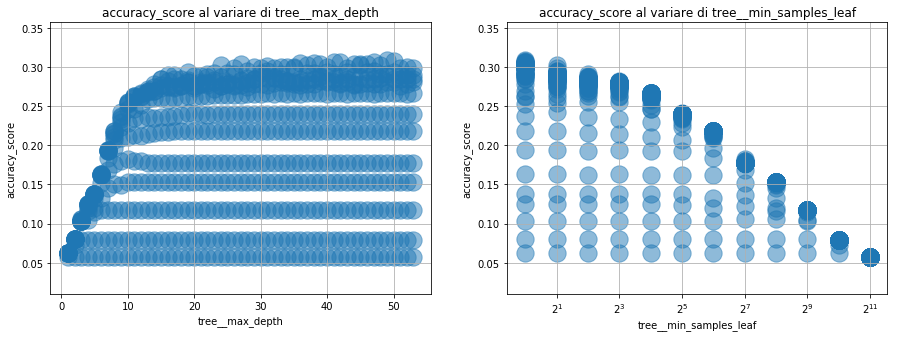

In [31]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "tree__max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "tree__min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

In [34]:
from funzioni import grafico_metrica_iperparametri

print(inspect.getsource(grafico_metrica_iperparametri))

def grafico_metrica_iperparametri(risultati, iperparam1, iperparam2, metrica,
        alpha=0.75, s=300):
    plt.title("{} al variare di {} e {}".format(metrica, iperparam1,
        iperparam2))
    plt.scatter(risultati[iperparam1], risultati[iperparam2],
        c=risultati[metrica], cmap=plt.cm.RdBu_r, alpha=alpha, s=s)
    plt.colorbar()
    plt.xlabel(iperparam1)
    plt.ylabel(iperparam2)
    plt.grid()



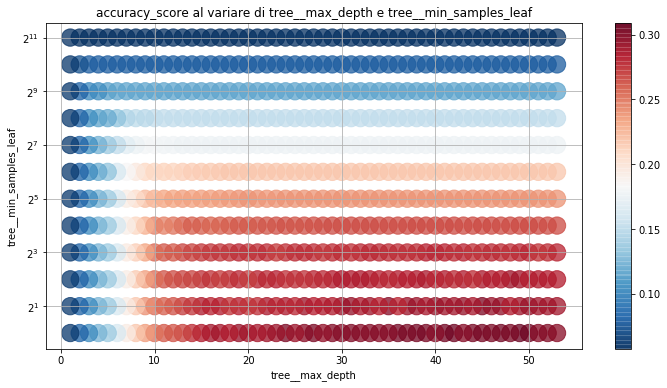

In [35]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "tree__max_depth", "tree__min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)

plt.show()